# 构建一个KNN分类器来进行图像分类

## K-NN原理介绍
K近邻算法(K-NN)算法是一种简单但也很常用的一种分类算法，它也可以应用于回归计算。K-NN是无参数学习,这意味着它不会对底层数据的分布做出任何假设。它是基于实例，即该算法没有显式地学习模型。相反，它选择的是记忆训练实例。并在一个有监督的学习环境中使用。KNN算法的实现过程主要包括距离计算方式的选择、k值得选取以及分类的决策规则三部分。  
#### 1. 距离计算方式的选择
选择一种距离计算方式,计算测试数据与各个训练数据之间的距离。距离计算方式一般选择欧氏距离或曼哈顿距离。   
给定训练集: $ X_{train} = (x^{(1)},x^{(2)},x^{(3)},...,x^{(i)}) $，测试集：$ X_{test} = ({x'}^{(1)},{x'}^{(2)},{x'}^{(3)},...,{x'}^{(j)}) $  
则欧式距离为：  $$ d(x^{(i)},{x'}^{(j)}) = \sqrt{\sum_{l=1}^l (x_{l}^{(i)}-{x_{l}'}^{(j)})^{2}} \tag{1} $$
曼哈顿距离为：  $$ d(x^{(i)},{x'}^{(j)}) = {\sum_{l=1}^l \left| {x_{l}^{(i)}-{x_{l}'}^{(j)}}\right| \tag{2}} $$
#### 2. k值得选取
在计算测试数据与各个训练数据之间的距离之后，首先按照距离递增次序进行排序，然后选取距离最小的k个点。  
一般会先选择较小的k值，然后进行交叉验证选取最优的k值。k值较小时，整体模型会变得复杂，且对近邻的训练数据点较为敏感，容易出现过拟合。k值较大时，模型则会趋于简单，此时较远的训练数据点也会起到预测作用，容易出现欠拟合。
#### 3. 分类的决策规则
常用的分类决策规则是取k个近邻训练数据中类别出现次数最多者作为输入新实例的类别。即首先确定前k个点所在类别的出现频率，对于离散分类，返回前k个点出现频率最多的类别作预测分类；对于回归则返回前k个点的加权值作为预测值。  

## 学习目标
- 不使用循环计算测试数据与训练数据的距离
- 构建KNN分类器来进行图像二分类
- 构建KNN分类器来进行图像多分类

## 构建KNN分类器来进行图像二分类

## 第一步：数据预处理

### 导入库

In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

E:\ruanjian\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 导入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 将数据集转换为矢量

In [4]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

### 数据标准化

In [5]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 第二步：构建KNN分类器

### 计算距离(欧式距离)

In [6]:
def distance(X_test, X_train):
    """
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    输出:
    distances -- 测试数据与各个训练数据之间的距离,大小为(测试样本数, 训练样本数量)的numpy数组
    """
    num_test = X_test.shape[1]
    num_train = X_train.shape[1]
    distances = np.zeros((num_test, num_train))
    # (X_test - X_train)*(X_test - X_train) = -2X_test*X_train + X_test*X_test + X_train*X_train
    dist1 = np.multiply(np.dot(X_test.T,X_train), -2)    # -2X_test*X_train, shape (num_test, num_train)
    dist2 = np.sum(np.square(X_test.T), axis=1, keepdims=True)    # X_test*X_test, shape (num_test, 1)
    dist3 = np.sum(np.square(X_train), axis=0,keepdims=True)    # X_train*X_train, shape(1, num_train)
    distances = np.sqrt(dist1 + dist2 + dist3)

    return distances

## 第三步：定义预测函数

In [7]:
def predict(X_test, X_train, Y_train, k = 1):
    """ 
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    k -- 选取与训练集最近邻的数量
    输出:
    Y_prediction -- 包含X_test中所有预测值的numpy数组（向量）
    distances -- 由numpy数组表示的测试数据与各个训练数据之间的距离,大小为(测试样本数, 训练样本数)
    """
    distances = distance(X_test, X_train)
    num_test = X_test.shape[1]
    Y_prediction = np.zeros(num_test)
    for i in range(num_test):
        dists_min_k = np.argsort(distances[i])[:k]     # 按照距离递增次序进行排序,选取距离最小的k个点 
        y_labels_k = Y_train[0,dists_min_k]     # 确定前k个点的所在类别
        Y_prediction[i] = np.argmax(np.bincount(y_labels_k)) # 返回前k个点中出现频率最高的类别作为测试数据的预测分类

    return Y_prediction, distances

### 定义模型

In [8]:
def model(X_test, Y_test, X_train, Y_train, k = 1, print_correct = False):
    """
    输入：
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    Y_test -- 由numpy数组（向量）表示的测试标签，大小为 (1, 测试样本数)
    k -- 选取与训练集最近邻的数量
    print_correct -- 设置为true时，打印正确率
    输出：
    d -- 包含模型信息的字典
    """
    Y_prediction, distances = predict(X_test, X_train, Y_train, k)
    num_correct = np.sum(Y_prediction == Y_test)
    accuracy = np.mean(Y_prediction == Y_test)
    if print_correct:
        print('Correct %d/%d: The test accuracy: %f' % (num_correct, X_test.shape[1], accuracy))
    d = {"k": k,
         "Y_prediction": Y_prediction, 
         "distances" : distances,
         "accuracy": accuracy}
    return d

### 测试模型

In [10]:
d = model(test_set_x, test_set_y,train_set_x, train_set_y, k=1, print_correct = True)

Correct 37/50: The test accuracy: 0.740000


y = 1, you predicted that it is a "cat" picture.


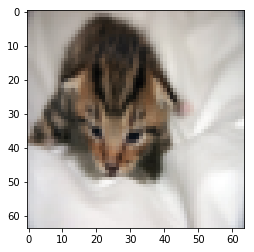

In [12]:
num_px = train_set_x_orig.shape[1]
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction"][index])].decode('utf-8') +  "\" picture.")

## 构建KNN分类器来进行图像多分类
### 导入数据集

In [13]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y
def load_CIFAR10():
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join('datasets', 'cifar-10-batches-py', 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join('datasets', 'cifar-10-batches-py', 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [14]:
X_train, y_train, X_test, y_test = load_CIFAR10()

### CIFAR-10数据集介绍
CIFAR-10数据集共有60000张彩色图像，每张图像大小为32*32*3，分为10个类，每类6000张图片。其中训练集包含50000张图像，测试集包含10000张图像。
### CIFAR-10数据集部分图像可视化

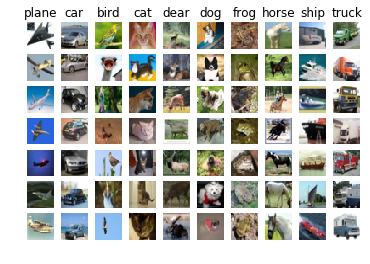

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### 取训练集的前10000个样本与测试集的前1000个样本

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], -1)).T
X_test = np.reshape(X_test, (X_test.shape[0], -1)).T
Y_set_train = y_train[:10000].reshape(1,-1)
Y_set_test = y_test[:1000].reshape(1,-1)
X_set_train = X_train[:,:10000]
X_set_test = X_test[:,:1000]

### 取不同的k值进行训练

In [20]:
models = {}
for k in [1, 3, 5, 10]:
    print ("k = " + str(k))
    models[str(k)] = model(X_set_test, Y_set_test, X_set_train, Y_set_train, k, print_correct = True)
    print ('\n' + "-------------------------------------------------------" + '\n')

k = 1
Correct 283/1000: The test accuracy: 0.283000

-------------------------------------------------------

k = 3
Correct 280/1000: The test accuracy: 0.280000

-------------------------------------------------------

k = 5
Correct 296/1000: The test accuracy: 0.296000

-------------------------------------------------------

k = 10
Correct 288/1000: The test accuracy: 0.288000

-------------------------------------------------------



### 画出不同k值对应的测试精度曲线

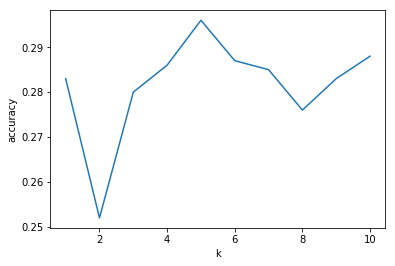

In [18]:
models = {}
k = []
accuracys = []
for i in range(1,11):
    models[str(i)] = model(X_set_test, Y_set_test, X_set_train, Y_set_train, i, print_correct = False)
    k.append(models[str(i)]["k"])
    accuracys.append(models[str(i)]["accuracy"])
plt.plot(k, accuracys)
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()